<a href="https://colab.research.google.com/github/marfiori/covid19-decoupling/blob/main/decoupling_and_immunization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
""" Code used in the paper:
SARS-CoV-2 epidemic in the South American Southern cone: can combined immunity from vaccination
 and infection prevent the spread of Gamma and Lambda variants while easing restrictions? 
 Marcelo Fiori, Gonzalo Bello, Nicolás Wschebor, Federico Lecumberry, Andrés Ferragut, and Ernesto Mordecki"""

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib import rc
from datetime import timedelta
from scipy.stats import pearsonr, linregress
from sklearn import linear_model
from itertools import combinations, cycle
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus']=False

plt.style.use("seaborn-darkgrid")
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Load Google mobility data
google= pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', delimiter=',')
google['date'] = pd.to_datetime(google['date'])
google.rename(columns={'residential_percent_change_from_baseline':'res'}, inplace=True)
google.rename(columns={'workplaces_percent_change_from_baseline':'work'}, inplace=True)
google.rename(columns={'parks_percent_change_from_baseline':'parks'}, inplace=True)
google.rename(columns={'retail_and_recreation_percent_change_from_baseline':'com'}, inplace=True)
google.rename(columns={'grocery_and_pharmacy_percent_change_from_baseline':'esen'}, inplace=True)
google.rename(columns={'transit_stations_percent_change_from_baseline':'transit'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Select country to run the experiment
#country = 'Argentina'
#country = 'Brazil'
country = 'Chile'
country = 'Paraguay'
#country = 'Uruguay'

In [4]:
init_date = pd.to_datetime('2020-05-30')

# Load data from OWID
dfowid= pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', delimiter=',')
dfowid['date'] = pd.to_datetime(dfowid['date'])
dfowid = dfowid[(dfowid['date'] >= init_date)]
dfowid['new_cases'] = dfowid['new_cases'].clip(lower=0)

# Approximate start date of vaccination campaings 
vaccination_start_ar = pd.to_datetime('2021-03-11') 
vaccination_start_uy = pd.to_datetime('2021-03-15') 
vaccination_start_cl = pd.to_datetime('2021-02-08')
vaccination_start_py = pd.to_datetime('2021-03-15') 
vaccination_start_bz = pd.to_datetime('2021-03-15') 

june = pd.to_datetime('2021-06-01')
july = pd.to_datetime('2021-07-01') 
august = pd.to_datetime('2021-08-01') 

# IFR for each country, with its corresponding confidence interval (left and right). See Table 1 in paper.
ifr_ar = 0.671; ifr_ar_l = 0.36; ifr_ar_r = 1.3;
ifr_bz = 0.594; ifr_bz_l = 0.32; ifr_bz_r = 1.17;
ifr_cl = 0.737; ifr_cl_l = 0.4; ifr_cl_r = 1.43;
ifr_py = 0.418; ifr_py_l = 0.23; ifr_py_r = 0.83;
ifr_uy = 0.906; ifr_uy_l = 0.49; ifr_uy_r = 1.56;
ifr_il = 0.650; ifr_il_l = 0.35; ifr_il_r = 1.27;

# Estimated vaccine effectiveness
ef_vin = 0.66  # virus inactivated vaccines
ef_adv = 0.73  # adenovirus vaccines
ef_arn = 0.93  # RNA vaccine

# Estimated vaccine effectiveness per country, using percentage of vaccines used in each country. See Table 1 in paper.
ef_ar = 0.311*ef_vin + 0.647*ef_adv + 0.042*ef_arn
ef_bz = 0.344*ef_vin + 0.481*ef_adv + 0.175*ef_arn
ef_cl = 0.711*ef_vin + 0.069*ef_adv + 0.22*ef_arn 
ef_py = 0.116*ef_vin + 0.266*ef_adv + 0.618*ef_arn
ef_uy = 0.598*ef_vin + 0.016*ef_adv + 0.386*ef_arn
ef_il = ef_arn

# Size of time window used for the regression
fit_window_back = 75
fit_window_forward = 55

# Decoupling threshold
decoupling_th = 1.1 

if country == 'Chile': vaccination_start = vaccination_start_cl; ifr = ifr_cl; ifr_l = ifr_cl_l; ifr_r = ifr_cl_r; effectiveness = ef_cl
if country == 'Uruguay': vaccination_start = vaccination_start_uy; ifr = ifr_uy; ifr_l = ifr_uy_l; ifr_r = ifr_uy_r; effectiveness = ef_uy
if country == 'Paraguay': vaccination_start = vaccination_start_py; ifr = ifr_py; ifr_l = ifr_py_l; ifr_r = ifr_py_r; effectiveness = ef_py
if country == 'Argentina': vaccination_start = vaccination_start_ar; ifr = ifr_ar; ifr_l = ifr_ar_l; ifr_r = ifr_ar_r; effectiveness = ef_ar
if country == 'Brazil': vaccination_start = vaccination_start_bz; ifr = ifr_bz; ifr_l = ifr_bz_l; ifr_r = ifr_bz_r; effectiveness = ef_bz
if country == 'Israel': vaccination_start = vaccination_start_il; ifr = ifr_il; ifr_l = ifr_il_l; ifr_r = ifr_il_r; effectiveness = ef_il

df = dfowid.loc[dfowid['location'] == country]

In [5]:
# Percentage of people fully vaccinated
df['people_fully_vaccinated_per_hundred'] = df['people_fully_vaccinated_per_hundred'].interpolate(method='linear', limit_direction='forward')

# Percentage of people with Natural Immunity (NI), with its corresponding confidence interval
df['NI'] = (100/ifr)*df.total_deaths_per_million/10000
df['NI_inf'] = (100/ifr_r)*df.total_deaths_per_million/10000
df['NI_sup'] = (100/ifr_l)*df.total_deaths_per_million/10000

df['intersection'] = (df.people_fully_vaccinated_per_hundred*df.NI)/100

df['vaccinated_VE'] = df.people_fully_vaccinated_per_hundred*effectiveness
#df['immune'] = df.people_fully_vaccinated_per_hundred + df.NI

#df['immune_rest_inter'] = df.people_fully_vaccinated_per_hundred + df.NI - df.intersection

# Proportion of immunized population, with its corresponding confidence interval. See Section 4.3 of paper.
df['IM'] = (df.people_fully_vaccinated_per_hundred)*effectiveness + df.NI
df['IM_inf'] = (df.people_fully_vaccinated_per_hundred - df.intersection)*effectiveness + df.NI_inf
df['IM_sup'] = (df.people_fully_vaccinated_per_hundred - df.intersection)*effectiveness + df.NI_sup

In [6]:
# Select mobility series from the given country, and apply a moving average
window_mov = 14;
mov  = google.loc[(google['country_region'] == country) & (google['sub_region_1'].isnull()) & (google['sub_region_2'].isnull()) & (google['metro_area'].isnull())]
mov.res = mov.rolling(window_mov).res.mean()
mov.work = mov.rolling(window_mov).work.mean()
mov.com = mov.rolling(window_mov).com.mean()
mov.parks = mov.rolling(window_mov).parks.mean()
mov.esen = mov.rolling(window_mov).esen.mean()
mov.transit = mov.rolling(window_mov).transit.mean()

In [7]:
# Auxiliary function to compute the delay maximizing the correlation, for a given set of mobility categories
def opt_delay(mov,dfc,cates,init_date,end_date,figs=0):
    dmin = 6
    dmax = 21

    corresR = [];
    xr = dfc[(dfc['date'] >= init_date) & (dfc['date'] <= end_date)].reproduction_rate
    
    days = range(dmin,dmax)
    for dd in days:
        ymov = mov[(mov['date'] >= init_date - timedelta(days=dd)) & (mov['date'] <= end_date - timedelta(days=dd))]
        X = ymov[[cates[0],cates[1],cates[2]]].to_numpy()
        reg = linear_model.LinearRegression(); reg.fit(X, xr)
        yP = reg.predict(X);
        correR = pearsonr(xr, yP)
        corresR.append(correR[0])

    return days[np.argmax(corresR)], corresR[np.argmax(corresR)]


In [8]:
# Search for the best three mobility categories and the associated time delay
mov_cats = ['com','esen','parks','transit','work','res']

# Fitting window
init_date = vaccination_start - timedelta(days=fit_window_back)
end_date = vaccination_start + timedelta(days=fit_window_forward)

# Try every combination of 3 categories
max_cor = 0
li = combinations(mov_cats, 3) 
for cats in list(li):
  ddss, corre = opt_delay(mov,df,cats,init_date,end_date)
  if corre>max_cor:
    max_cor = corre
    categories = cats
    dds = ddss

print('Country: ',country)
print('Correlation: ',max_cor)
print('Used categories: ',categories)
print('Delay (in days): ',dds)

# Fit linear regression model
dfr = df[(df['date'] >= init_date) & (df['date'] <= end_date)]
dfr2 = df[(df['date'] >= init_date)]
yr = dfr.reproduction_rate.to_numpy()
yr2 = dfr2.reproduction_rate.to_numpy()
dfmov = mov[(mov['date'] >= init_date - timedelta(days=dds)) & (mov['date'] <= end_date - timedelta(days=dds))]
dfmov2 = mov[(mov['date'] >= init_date - timedelta(days=dds))]
X = dfmov[[categories[0],categories[1],categories[2]]].to_numpy()
X2 = dfmov2[[categories[0],categories[1],categories[2]]].to_numpy()

reg = linear_model.LinearRegression();
reg.fit(X, yr)
yP = reg.predict(X); yP2 = reg.predict(X2);
corre = pearsonr(yP, yr)


dfmov3 = mov[(mov['date'] >= init_date - timedelta(days=dds)) & (mov['date'] <=dfr2['date'][dfr2.index[-1]] - timedelta(days=dds))]
X3 = dfmov3[[categories[0],categories[1],categories[2]]].to_numpy()
yP3 = reg.predict(X3)
coupling_ratio = yP3/yr2

fecha_last_Rgrtr1 = (df[(df['reproduction_rate'] > 1) & (df['date'] < august)]).date.max()
print('Last time R>1: ',fecha_last_Rgrtr1)
dfr2['coupling_ratio'] = coupling_ratio
decoupling_time = (dfr2[(dfr2['coupling_ratio'] > decoupling_th)]).date.min()
decoupling_time = (dfr2[(dfr2['coupling_ratio'] > decoupling_th) & (dfr2['date'] > end_date)]).date.min()
decoupling_time = (dfr2[(dfr2['coupling_ratio'] < decoupling_th)]).date.max() + timedelta(days=1)


print('Decoupling time: ',decoupling_time)
print("Natural immunization % at decoupling time: ", round((df[df.date==decoupling_time].NI.item()),0),"(" + str(round((df[df.date==decoupling_time].NI_inf.item()),0)) + "-" + str(round((df[df.date==decoupling_time].NI_sup.item()),0)) + ")")
print("Fully vaccinated % at decoupling time: ", round((df[df.date==decoupling_time].people_fully_vaccinated_per_hundred.item()),0))
print("Immune population by vaccination % at decoupling time: ", round((df[df.date==decoupling_time].vaccinated_VE.item()),0))
print("Immune population % at decoupling time: ", str(round((df[df.date==decoupling_time].IM.item()),0)) + "(" + str(round((df[df.date==decoupling_time].IM_inf.item()),0)) + "-" + str(round((df[df.date==decoupling_time].IM_sup.item()),0)) + ")")

Country:  Paraguay
Correlation:  0.8670249976782591
Used categories:  ('esen', 'work', 'res')
Delay (in days):  6
Last time R>1:  2021-06-05 00:00:00
Decoupling time:  2021-06-11 00:00:00
Natural immunization % at decoupling time:  35.0 (18.0-64.0)
Fully vaccinated % at decoupling time:  2.0
Immune population by vaccination % at decoupling time:  1.0
Immune population % at decoupling time:  36.0(19.0-65.0)


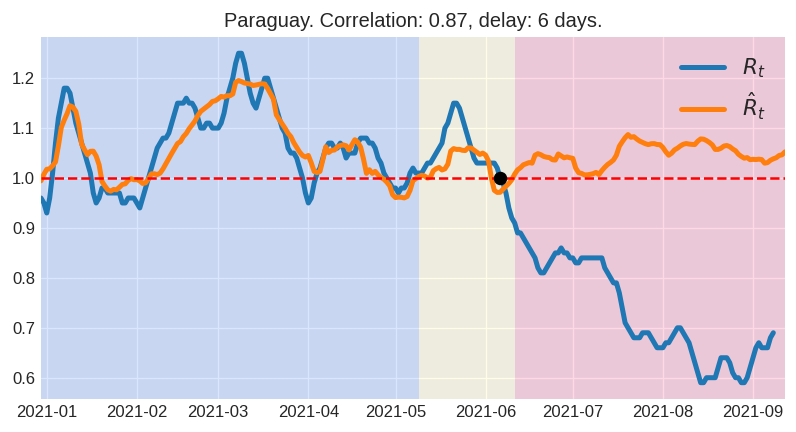

In [9]:
# Figure 1 in paper

alpha = 0.2
col = "#4286f4"
col2 = "#f44174"
col3 = "#fff68f"

fig, ax = plt.subplots(figsize=(8, 4),dpi=120)
plt.plot(dfr2.date,dfr2.reproduction_rate,label=r'$R_t$',linewidth=3)
plt.plot(dfmov3.date+timedelta(days=dds),yP3,label=r'$\hat{R}_t$',linewidth=3)
plt.axhline(y=1,color='red',ls='--')
plt.title(country + '. Correlation: ' + str(round(corre[0],2)) + ", delay: " + str(dds) + " days.")
plt.legend(fontsize=13)
ax.axvspan(pd.Timestamp(init_date), pd.Timestamp(end_date), facecolor=col, alpha=alpha)
ax.axvspan(pd.Timestamp(end_date), pd.Timestamp(decoupling_time), facecolor=col3, alpha=alpha)
ax.axvspan(pd.Timestamp(decoupling_time), dfr2['date'][dfr2.index[-1]], facecolor=col2, alpha=alpha)
ax.set_xlim(pd.Timestamp(init_date), dfr2['date'][dfr2.index[-1]]) 
plt.scatter(pd.Timestamp(fecha_last_Rgrtr1)+ timedelta(days=1),1,s=50,color='k',zorder=10)
plt.show()

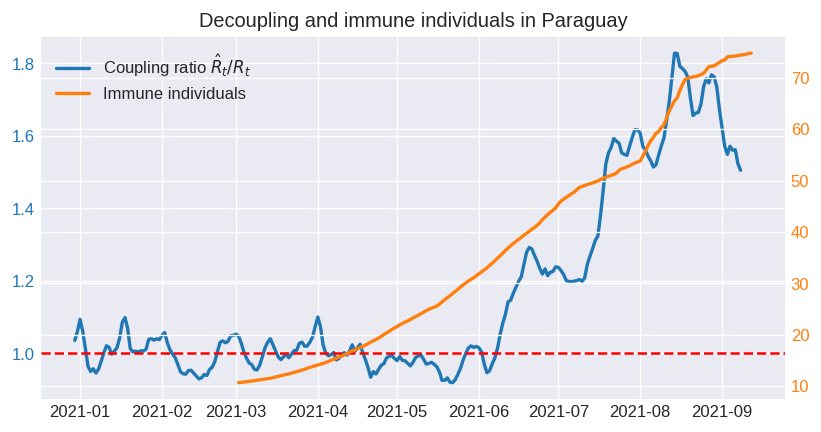

In [10]:
# Figure (not present in paper) showing coupling factor and immune population along time
fig, ax1 = plt.subplots(dpi=120,figsize=(8,4))
lns1 = ax1.plot(dfr2.date,coupling_ratio,color='tab:blue',label=r'Coupling ratio $\hat{R}_t/R_t$',linewidth=2)
ax1.axhline(y=1,color='r',ls='--')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
lns2 = ax2.plot(dfr2.date,dfr2.IM,color='tab:orange',label='Immune individuals',linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:orange')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)
plt.title('Decoupling and immune individuals in ' + country)
plt.show()

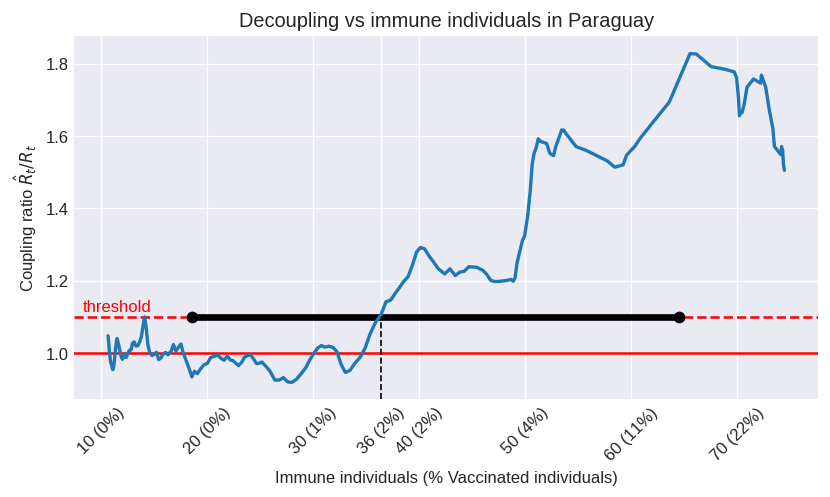

In [11]:
# Figure 2 in paper
HIT=df[df.date==decoupling_time].IM.item()
HIT_inf=df[df.date==decoupling_time].IM_inf.item()
HIT_sup=df[df.date==decoupling_time].IM_sup.item()

fig, ax3 = plt.subplots(dpi=120,figsize=(8,4))
ax3.plot(dfr2.IM,dfr2.coupling_ratio,color='tab:blue',linewidth=2,zorder=10)
ax3.plot([HIT_inf, HIT_sup],[decoupling_th,decoupling_th],'o-',color='black',linewidth=4,zorder=9)
plt.title('Decoupling vs immune individuals in ' + country)
plt.xlabel('Immune individuals (% Vaccinated individuals)')
plt.ylabel(r'Coupling ratio $\hat{R}_t/R_t$')
ax3.axhline(y=decoupling_th,color='red',ls='--')
ax3.axhline(y=1,color='red',ls='-')
plt.text(ax3.get_xlim()[0]+0.8, decoupling_th+0.015, 'threshold',color='red',fontsize=10)
fig.canvas.draw()

ett = [HIT] 
plt.xticks(list(plt.xticks()[0]) + ett)
labels = [item.get_text() for item in ax3.get_xticklabels()]
for k in range(len(labels)):
  if k==len(labels)-1:
    labels[k] = str(round(HIT,0))
  result_index = df['IM'].sub(float(labels[k])).abs().idxmin()
  labels[k] = labels[k] + " (" + str(round(df.loc[result_index].people_fully_vaccinated_per_hundred)) + "%)"
  if k==len(labels)-1:
    labels[k] = str(int(HIT)) + " (" + str(round(df.loc[result_index].people_fully_vaccinated_per_hundred)) + "%)"

ax3.set_xticklabels(labels)
liminfy = ax3.get_ylim()[0]
limsupy = ax3.get_ylim()[1]
ax3.plot([HIT, HIT],[liminfy,decoupling_th],'--',color='black',linewidth=1,zorder=7)
ax3.set_ylim(bottom=liminfy)

for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(10) 
    tick.label.set_rotation(45)
plt.show()